In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from kornia.contrib import connected_components
from tqdm import tqdm

In [2]:
%load_ext autoreload
%autoreload 1

In [3]:
from uloss_wmh.loss_functions.neven import *

In [4]:
"""
I need to construct an example.
For that example, I need to construct an example vector map, a seed map
and two instances lets say.

I need a:

[ ] mask
[ ] example vector map
[ ] spatial dims
[ ] 
"""

'\nI need to construct an example.\nFor that example, I need to construct an example vector map, a seed map\nand two instances lets say.\n\nI need a:\n\n[ ] mask\n[ ] example vector map\n[ ] spatial dims\n[ ] \n'

In [5]:
from ulw_data.torch_dataset.challenge_data_pipeline import train_data_pipeline

In [7]:
collated_folder = "/media/benp/NVMEspare/datasets/full_WMH_Chal_dataset/preprocessed/collated/"
train_ds, val_ds = train_data_pipeline(ds_path=collated_folder, val_proportion=0.15, seed=5, transforms=None, dims=2)

In [422]:
for i, data in enumerate(train_ds):
    print(i, data['label'][0].sum().item(), end="   ")

0 0   1 0   2 0   3 0   4 0   5 0   6 0   7 0   8 0   9 0   10 0   11 0   12 0   13 9   14 1   15 0   16 4   17 7   18 69   19 138   20 114   21 115   22 127   23 110   24 172   25 146   26 198   27 169   28 195   29 208   30 118   31 15   32 25   33 0   34 0   35 2   36 4   37 18   38 0   39 0   40 0   41 0   42 0   43 0   44 0   45 0   46 0   47 0   48 0   49 0   50 0   51 0   52 0   53 0   54 0   55 0   56 0   57 5   58 26   59 36   60 41   61 51   62 109   63 99   64 104   65 110   66 101   67 108   68 134   69 171   70 270   71 235   72 66   73 36   74 62   75 37   76 40   77 27   78 50   79 103   80 82   81 23   82 0   83 0   84 0   85 0   86 0   87 0   88 0   89 0   90 0   91 0   92 0   93 0   94 0   95 0   96 0   97 0   98 0   99 0   100 0   101 6   102 30   103 61   104 100   105 71   106 16   107 39   108 25   109 22   110 18   111 36   112 80   113 96   114 21   115 10   116 17   117 0   118 0   119 0   120 0   121 0   122 6   123 0   124 0   125 0   126 0   127 0   128 0   

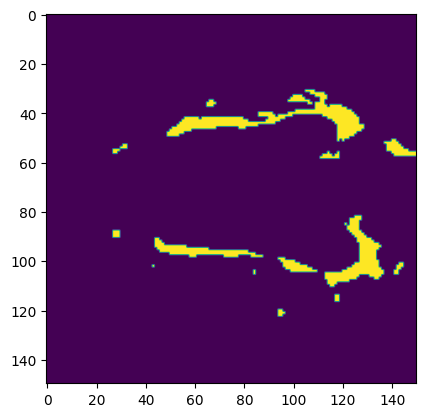

In [424]:
example_label = train_ds[1992]['label'][0][25:175, 25:175]
plt.imshow(example_label)

In [426]:
batch_elem0 = train_ds[67]['label'][0][25:175, 25:175].unsqueeze(0).type(torch.float32)
batch_elem1 = train_ds[107]['label'][0][25:175, 25:175].unsqueeze(0).type(torch.float32)
batch_elem2 = train_ds[718]['label'][0][25:175, 25:175].unsqueeze(0).type(torch.float32)
batch_elem3 = train_ds[1992]['label'][0][25:175, 25:175].unsqueeze(0).type(torch.float32)
batch = [batch_elem0, batch_elem1, batch_elem2, batch_elem3]

In [9]:
import kornia

In [10]:
ccs = kornia.contrib.connected_components(example_label.unsqueeze(0).unsqueeze(0).type(torch.float32), num_iterations=350)

In [427]:
example_label_instances_batch = [kornia.contrib.connected_components(b, num_iterations=350) for b in batch]

In [436]:
example_label_instances_batch = torch.stack(example_label_instances_batch)

In [437]:
example_label_instances_batch.shape

torch.Size([4, 1, 150, 150])

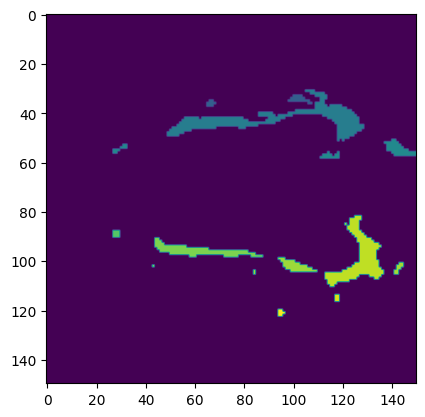

In [434]:
plt.imshow(example_label_instances_batch[3].squeeze())

In [439]:
example_label_instances_batch.shape

torch.Size([4, 1, 150, 150])

In [440]:
from monai.losses import DiceLoss

In [441]:
base_loss = DiceLoss(
    sigmoid=False,
    softmax=False,
    reduction='sum',
)

### Testing my implementation of neven

In [442]:
torch.Tensor([1,2]).shape

torch.Size([2])

### Overfitting on the one image

In [504]:
%autoreload

In [505]:
from uloss_wmh.loss_functions.neven_concurrent import *

In [648]:
activ = lambda x : torch.nn.functional.relu(x) * 5 + 5e-3#0.005
activ2 = lambda x : torch.sigmoid(x) + 0.001

In [681]:
neven_loss = NevenLoss(
    base_loss = DiceLoss(sigmoid=False,softmax=False, reduction='sum'),
    sigma_normalizer=activ,
    true_spatial_dims=(150,150),
    embedding_spatial_dims= (32, 32, 32, 32, 32), #, 64),
    embedding_rescale_factor=1/32,
    instance_weight=10,
    seed_weight=1,
    smooth_weight=0.1,
    debug=False
)

In [682]:
neven_loss.embedding_vectors.spatial_dims_to_embedding_dims_factor

tensor([[[0.2133]],

        [[0.2133]],

        [[1.0000]],

        [[1.0000]],

        [[1.0000]]])

In [683]:
# just define a random input embedding vector
offset_vector_random = torch.randn(4, 5, 150, 150).cuda() * 0.1
sigma_map_random = 0.05 + torch.randn(4,5,150,150).cuda() * 0.01 # + 1 #+ -2.02 #-3.9#torch.randn(1, 2, 150, 150) * 3
seed_map_random = 0.01+ torch.randn(4, 1, 150, 150).cuda() * 0.1

class InputsWrapper(torch.nn.Module):
    def __init__(self, offset_vector_random, sigma_map_random, seed_map_random):
        super().__init__()

        self.offset_vector_random = torch.nn.Parameter(offset_vector_random)
        self.sigma_map_random = torch.nn.Parameter(sigma_map_random)
        # self.log_2pres_squared_random = log_2pres_squared_random
        self.seed_map_random = torch.nn.Parameter(seed_map_random)
        self.instance_distributions = []
        
    def forward(self):
        loss, instance_distributions, (ins, smth, seed) = neven_loss(
            offset_map=self.offset_vector_random,
            # log_2pres_squared=(self.log_2pres_squared_random.tanh() * 2) - 4.6,
            sigma_map=self.sigma_map_random,
            seed_map=self.seed_map_random,
            labels=example_label_instances_batch.cuda(),
        )
        self.instance_distributions.append(instance_distributions)

        return loss, (ins, smth, seed)

In [684]:
model = InputsWrapper(offset_vector_random, sigma_map_random, seed_map_random)

In [685]:
optimizer = torch.optim.SGD(model.parameters(), lr=4)

In [711]:
for i in tqdm(range(8001)):
    loss, (ins, smth, seed) = model()
    loss.backward()
    if i % 500 == 0:
        print("LOSS: ", loss.item(), ins.item(), smth.item(), seed.item())
        print(model.offset_vector_random.data[0][0][60][40])
        print(model.offset_vector_random.grad[0][0][60][40])
    optimizer.step()
    optimizer.zero_grad()

  0%|                                                                                                                                                       | 4/10001 [00:00<11:39, 14.30it/s]

LOSS:  0.13608360290527344 0.05021495372056961 0.005669944453984499 0.04161786288022995
tensor(0.0135, device='cuda:0')
tensor(0., device='cuda:0')


  5%|███████▍                                                                                                                                             | 502/10001 [00:34<11:10, 14.17it/s]

LOSS:  0.1331789642572403 0.04934639856219292 0.005505937617272139 0.038701269775629044
tensor(0.0135, device='cuda:0')
tensor(0., device='cuda:0')


 10%|██████████████▊                                                                                                                                     | 1002/10001 [01:09<10:06, 14.84it/s]

LOSS:  0.1305006444454193 0.04856501892209053 0.0052805026061832905 0.035824358463287354
tensor(0.0135, device='cuda:0')
tensor(0., device='cuda:0')


 15%|██████████████████████▎                                                                                                                             | 1504/10001 [01:43<09:21, 15.12it/s]

LOSS:  0.12793809175491333 0.047802042216062546 0.0049989246763288975 0.03323202207684517
tensor(0.0135, device='cuda:0')
tensor(0., device='cuda:0')


 20%|█████████████████████████████▋                                                                                                                      | 2002/10001 [02:16<08:59, 14.84it/s]

LOSS:  0.1256493180990219 0.04713021591305733 0.0046530053950846195 0.030829831957817078
tensor(0.0135, device='cuda:0')
tensor(0., device='cuda:0')


 25%|█████████████████████████████████████                                                                                                               | 2502/10001 [02:52<08:33, 14.61it/s]

LOSS:  0.1229972392320633 0.0462878979742527 0.004274073056876659 0.02868257462978363
tensor(0.0135, device='cuda:0')
tensor(0., device='cuda:0')


 30%|████████████████████████████████████████████▍                                                                                                       | 3002/10001 [03:27<08:10, 14.27it/s]

LOSS:  0.1207132562994957 0.045582134276628494 0.003900449723005295 0.02664165012538433
tensor(0.0135, device='cuda:0')
tensor(0., device='cuda:0')


 35%|███████████████████████████████████████████████████▊                                                                                                | 3502/10001 [04:04<07:36, 14.24it/s]

LOSS:  0.11880788207054138 0.04502641037106514 0.0035830128472298384 0.02460912987589836
tensor(0.0135, device='cuda:0')
tensor(0., device='cuda:0')


 40%|███████████████████████████████████████████████████████████▎                                                                                        | 4004/10001 [04:39<06:42, 14.89it/s]

LOSS:  0.11720568686723709 0.044574711471796036 0.0034034939017146826 0.02273530885577202
tensor(0.0135, device='cuda:0')
tensor(0., device='cuda:0')


 45%|██████████████████████████████████████████████████████████████████▌                                                                                 | 4502/10001 [05:16<06:16, 14.62it/s]

LOSS:  0.1149018257856369 0.04382055625319481 0.00337377586401999 0.021064335480332375
tensor(0.0135, device='cuda:0')
tensor(0., device='cuda:0')


 50%|██████████████████████████████████████████████████████████████████████████                                                                          | 5002/10001 [05:51<06:11, 13.44it/s]

LOSS:  0.11005726456642151 0.04202207550406456 0.00341125694103539 0.01966717280447483
tensor(0.0135, device='cuda:0')
tensor(0., device='cuda:0')


 55%|█████████████████████████████████████████████████████████████████████████████████▍                                                                  | 5502/10001 [06:26<05:15, 14.25it/s]

LOSS:  0.10914827138185501 0.041804879903793335 0.003459465689957142 0.018198329955339432
tensor(0.0135, device='cuda:0')
tensor(0., device='cuda:0')


 60%|████████████████████████████████████████████████████████████████████████████████████████▊                                                           | 6002/10001 [07:01<04:32, 14.66it/s]

LOSS:  0.10735781490802765 0.04121837019920349 0.0035178144462406635 0.016895785927772522
tensor(0.0135, device='cuda:0')
tensor(0., device='cuda:0')


 65%|████████████████████████████████████████████████████████████████████████████████████████████████▏                                                   | 6503/10001 [07:47<05:27, 10.67it/s]

LOSS:  0.10647670179605484 0.04098975285887718 0.0035657393746078014 0.01565268635749817
tensor(0.0135, device='cuda:0')
tensor(0., device='cuda:0')


 66%|█████████████████████████████████████████████████████████████████████████████████████████████████▎                                                  | 6573/10001 [12:52<06:42,  8.51it/s]Exception ignored in: <generator object tqdm.__iter__ at 0x7fb5fe3f7450>
Traceback (most recent call last):
  File "/home/benp/.local/lib/python3.10/site-packages/tqdm/std.py", line 1193, in __iter__
  File "/home/benp/.local/lib/python3.10/site-packages/tqdm/std.py", line 1299, in close
  File "/home/benp/.local/lib/python3.10/site-packages/tqdm/std.py", line 1492, in display
    self.sp(self.__str__() if msg is None else msg)
  File "/home/benp/.local/lib/python3.10/site-packages/tqdm/std.py", line 347, in print_status
    fp_write('\r' + s + (' ' * max(last_len[0] - len_s, 0)))
  File "/home/benp/.local/lib/python3.10/site-packages/tqdm/std.py", line 341, in fp_write
    fp_flush()
  File "/home/benp/.local/lib/python3.10/site-packages/tqdm/utils.py", line 127, in inner
    return func(*args, **k

In [707]:
islice = 2

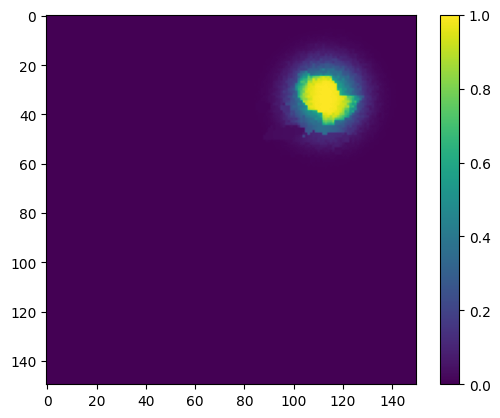

In [708]:
plt.imshow(model.instance_distributions[-1][islice][5].cpu(), vmin=0, vmax=1);
plt.colorbar();

In [709]:
model.instance_distributions[-1][0].shape

torch.Size([11, 150, 150])

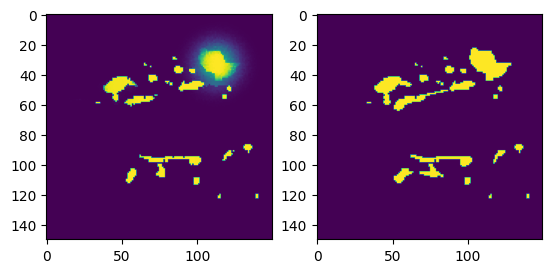

In [710]:
plt.subplot(1,2,1)
instances = torch.stack([inst for inst in model.instance_distributions[-1][islice]])
plt.imshow(instances.sum(dim=0), vmin=0, vmax=1)

plt.subplot(1,2,2)
plt.imshow(example_label_instances_batch[islice][0] != 0)

In [696]:
instances.shape

torch.Size([22, 150, 150])

In [697]:
example_label_instances.shape

torch.Size([1, 1, 150, 150])

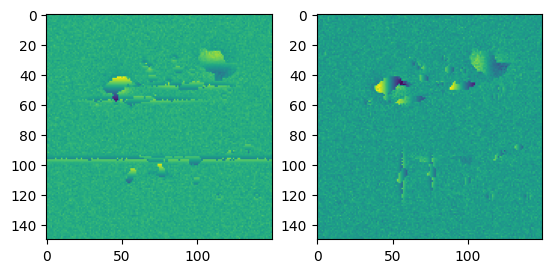

In [698]:
plt.subplot(1,2,1)
#offset_vector_random
#log_2pres_squared_random
#seed_map_random

#embedding = grid/150 + model.offset_vector_random.detach().tanh()
# embedding = grid + model.offset_vector_random.detach().cpu()
embedding = neven_loss.embedding_vectors(model.offset_vector_random.detach()).cpu()

# plt.imshow(embedding[0,1]); plt.colorbar()
# plt.imshow(model.log_2pres_squared_random[0,0].detach()); plt.colorbar()
# plt.imshow(model.seed_map_random[0,0].detach()); plt.colorbar()
plt.imshow(model.offset_vector_random.detach().cpu()[islice,0]);# plt.colorbar()
plt.subplot(1,2,2)
plt.imshow(model.offset_vector_random.detach().cpu()[islice,1]);# plt.colorbar()

In [703]:
points_random = embedding.reshape((4, 5, -1))

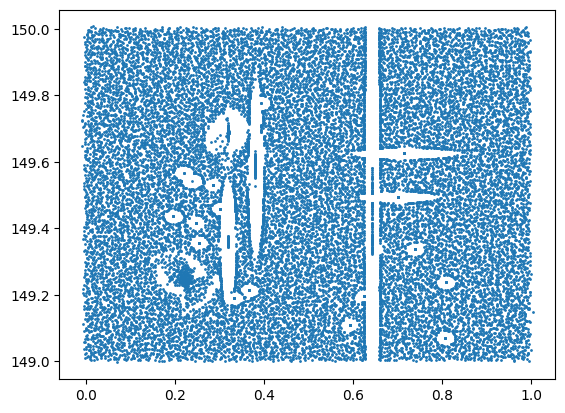

In [705]:
plt.scatter(points_random[islice, 0], 150-points_random[islice, 1], s=1)

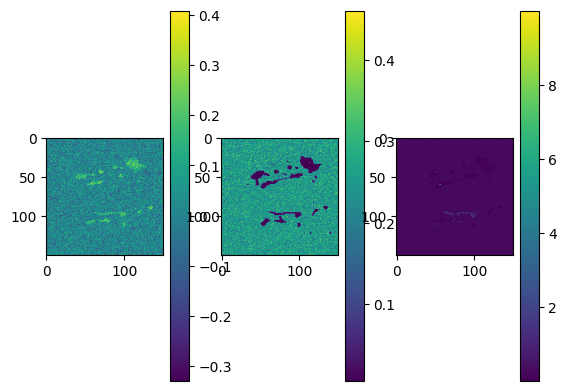

In [680]:
plt.subplot(1,3,1)
#offset_vector_random
#log_2pres_squared_random
#seed_map_random

sigma_random = activ(model.sigma_map_random)
plt.imshow(model.seed_map_random[islice,0].detach().cpu()); plt.colorbar()
plt.subplot(1,3,2)
plt.imshow(sigma_random[islice,0].detach().cpu()); plt.colorbar()
plt.subplot(1,3,3)
plt.imshow(sigma_random[islice,1].detach().cpu()); plt.colorbar()

### list of what is working or needs checking

- [x] trains with fixed centre and full scale vectors
- [x] trains with learned centre and full scale vectors (yes works even better)
- [ ] scaling down the vectors, does it still train?
- [ ] finding a suitable way to constrain log2pres does it train?